#### Imports & Downloads

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

import vector_functions

### Model Preparation

#### Functions

In [15]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [16]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [17]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [18]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [19]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train_cleaned.csv")

In [20]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 1304
- Negative: 18322
- Verhältnis: 14.050613496932515


In [21]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

id                   0
label                0
tweet                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           15439
dtype: int64

#### Vectorize - Word2Vec

In [22]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, w2v_model = vector_functions.vectorize_word2vec(df=df_train_cleaned,
                                                                                                  text_column="tweet_cleaned",
                                                                                                  label_column="label")

#### Vectorize - TF-IDF

In [23]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf, tf_model = vector_functions.vectorize_tfidf(df=df_train_cleaned,
                                                                                          text_column="tweet_cleaned",
                                                                                          label_column="label")

#### Vectorize - Glove

In [24]:
glove_path = "./glove/glove.twitter.27B.100d.txt"
X_train_gl, X_test_gl, y_train_gl, y_test_gl, gl_model = vector_functions.vectorize_glove(df=df_train_cleaned,
                                                                                          glove_path=glove_path,
                                                                                          text_column="tweet_cleaned",
                                                                                          label_column="label")

### Training Functions

In [25]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [26]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [27]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [28]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [29]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [30]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [31]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [32]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [33]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [34]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [35]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [36]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [37]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [38]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 93.56%
------------------------------------------------
Confusion Matrix:
      0  1
0  5505  9
1   370  4
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.31      0.01      0.02       374

    accuracy                           0.94      5888
   macro avg       0.62      0.50      0.49      5888
weighted avg       0.90      0.94      0.91      5888



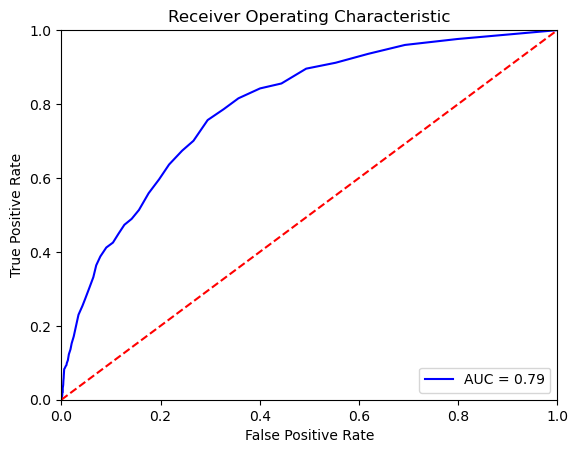

In [39]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.65%
------------------------------------------------
Confusion Matrix:
      0  1
0  5514  0
1   374  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.00      0.00      0.00       374

    accuracy                           0.94      5888
   macro avg       0.47      0.50      0.48      5888
weighted avg       0.88      0.94      0.91      5888



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


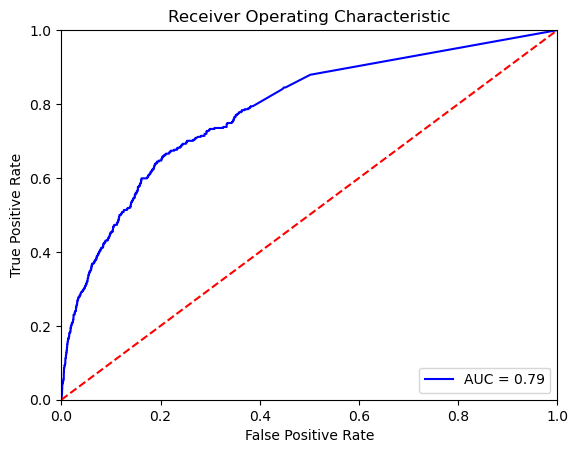

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.61%
------------------------------------------------
Confusion Matrix:
      0  1
0  5507  7
1   369  5
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.42      0.01      0.03       374

    accuracy                           0.94      5888
   macro avg       0.68      0.51      0.50      5888
weighted avg       0.90      0.94      0.91      5888



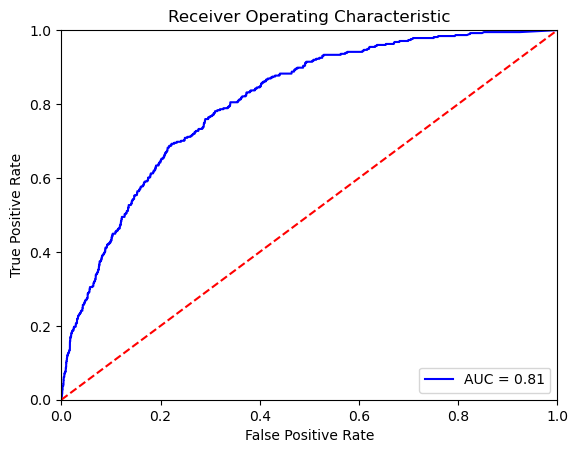

In [41]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 68.55%
------------------------------------------------
Confusion Matrix:
      0     1
0  3734  1780
1    72   302
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      5514
           1       0.15      0.81      0.25       374

    accuracy                           0.69      5888
   macro avg       0.56      0.74      0.52      5888
weighted avg       0.93      0.69      0.77      5888



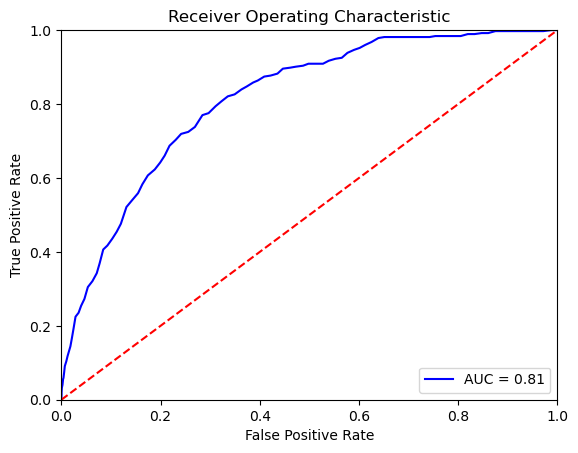

In [42]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.46%
------------------------------------------------
Confusion Matrix:
      0   1
0  5475  39
1   346  28
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5514
           1       0.42      0.07      0.13       374

    accuracy                           0.93      5888
   macro avg       0.68      0.53      0.55      5888
weighted avg       0.91      0.93      0.91      5888



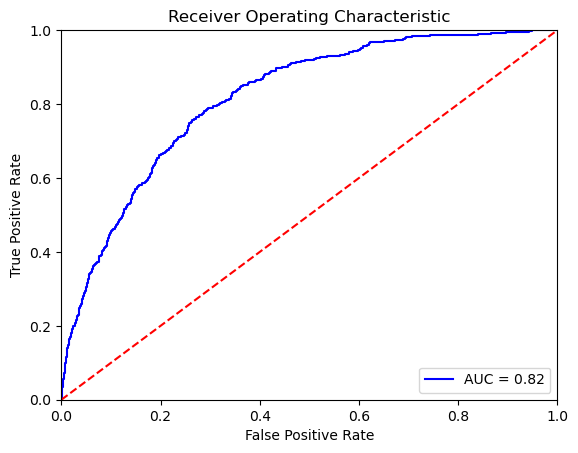

In [43]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.75%
------------------------------------------------
Confusion Matrix:
      0   1
0  5487  27
1   341  33
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.55      0.09      0.15       374

    accuracy                           0.94      5888
   macro avg       0.75      0.54      0.56      5888
weighted avg       0.92      0.94      0.92      5888



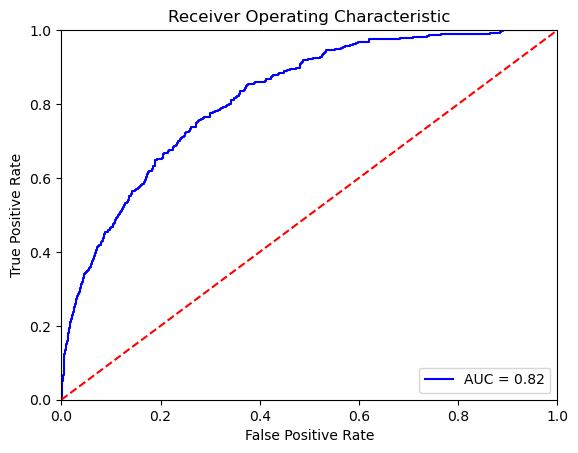

In [44]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.68%
------------------------------------------------
Confusion Matrix:
      0   1
0  5480  34
1   338  36
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5514
           1       0.51      0.10      0.16       374

    accuracy                           0.94      5888
   macro avg       0.73      0.55      0.56      5888
weighted avg       0.91      0.94      0.92      5888



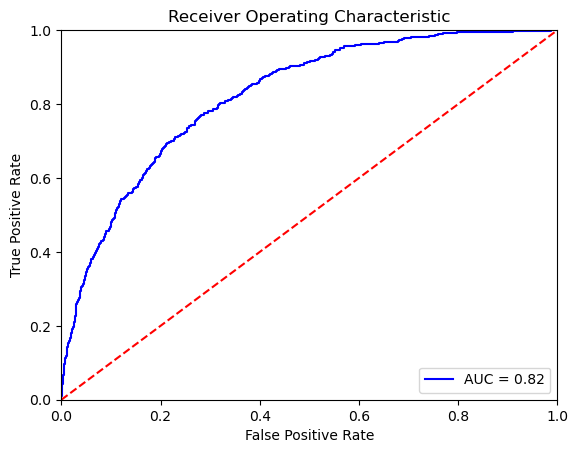

In [45]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:22:31] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 93.00%
------------------------------------------------
Confusion Matrix:
      0   1
0  5438  76
1   336  38
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5514
           1       0.33      0.10      0.16       374

    accuracy                           0.93      5888
   macro avg       0.64      0.54      0.56      5888
weighted avg       0.90      0.93      0.91      5888



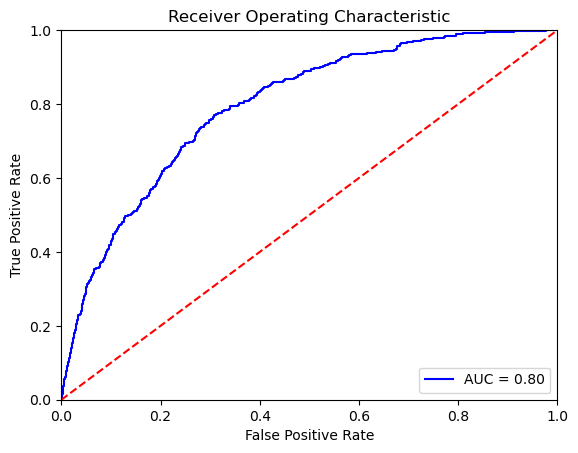

In [46]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.5792753	total: 195ms	remaining: 19.3s
1:	learn: 0.4905415	total: 238ms	remaining: 11.7s
2:	learn: 0.4285709	total: 279ms	remaining: 9.02s
3:	learn: 0.3784145	total: 329ms	remaining: 7.89s
4:	learn: 0.3395033	total: 363ms	remaining: 6.89s
5:	learn: 0.3124303	total: 389ms	remaining: 6.1s
6:	learn: 0.2903857	total: 437ms	remaining: 5.8s
7:	learn: 0.2756459	total: 468ms	remaining: 5.38s
8:	learn: 0.2648603	total: 511ms	remaining: 5.17s
9:	learn: 0.2562283	total: 565ms	remaining: 5.08s
10:	learn: 0.2495182	total: 616ms	remaining: 4.98s
11:	learn: 0.2428713	total: 663ms	remaining: 4.86s
12:	learn: 0.2370626	total: 695ms	remaining: 4.65s
13:	learn: 0.2315486	total: 742ms	remaining: 4.56s
14:	learn: 0.2279624	total: 788ms	remaining: 4.46s
15:	learn: 0.2250938	total: 852ms	remaining: 4.47s
16:	learn: 0.2220986	total: 920ms	remaining: 4.49s
17:	learn: 0.2196936	total: 952ms	remaining: 4.34s
18:	learn: 0.2175858	total: 983ms	remaining: 4.19s
19:	learn: 0.2156977	total: 1.01s	remaining

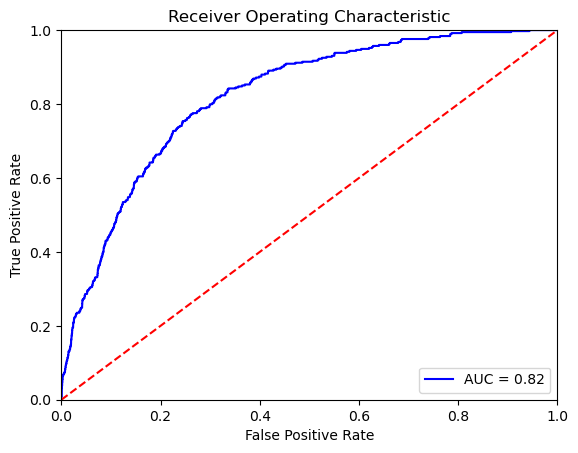

In [47]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

[LightGBM] [Info] Number of positive: 930, number of negative: 12807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 13737, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067700 -> initscore=-2.622563
[LightGBM] [Info] Start training from score -2.622563
model accuracy for classification is = 93.63%
------------------------------------------------
Confusion Matrix:
      0   1
0  5494  20
1   355  19
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.49      0.05      0.09       374

    accuracy                           0.94      5888
   macro avg       0.71      0.52      0.53      5888
weighted avg 

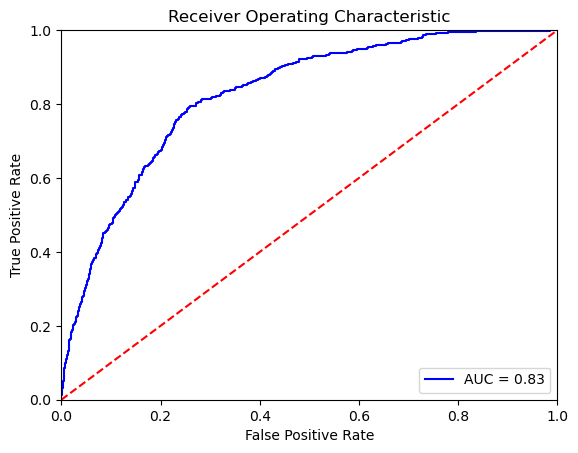

In [48]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.65%
------------------------------------------------
Confusion Matrix:
      0  1
0  5507  7
1   367  7
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.50      0.02      0.04       374

    accuracy                           0.94      5888
   macro avg       0.72      0.51      0.50      5888
weighted avg       0.91      0.94      0.91      5888



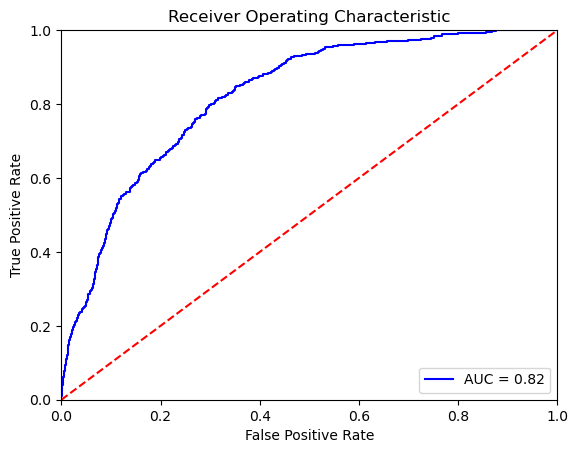

In [49]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

In [50]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### TF-IDF

model accuracy for classification is = 95.53%
------------------------------------------------
Confusion Matrix:
      0    1
0  5469   45
1   218  156
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5514
           1       0.78      0.42      0.54       374

    accuracy                           0.96      5888
   macro avg       0.87      0.70      0.76      5888
weighted avg       0.95      0.96      0.95      5888



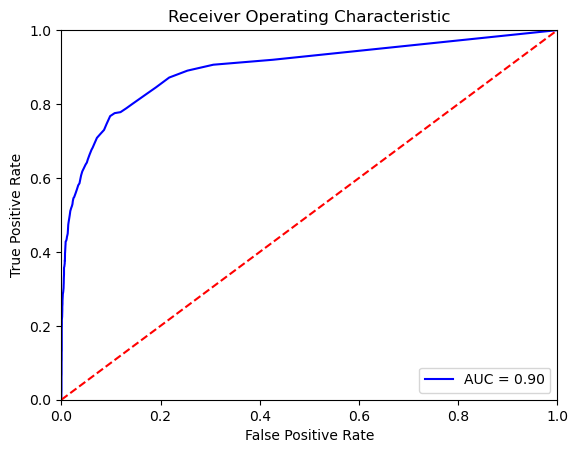

In [51]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.65%
------------------------------------------------
Confusion Matrix:
      0   1
0  5478  36
1   279  95
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.73      0.25      0.38       374

    accuracy                           0.95      5888
   macro avg       0.84      0.62      0.67      5888
weighted avg       0.94      0.95      0.93      5888



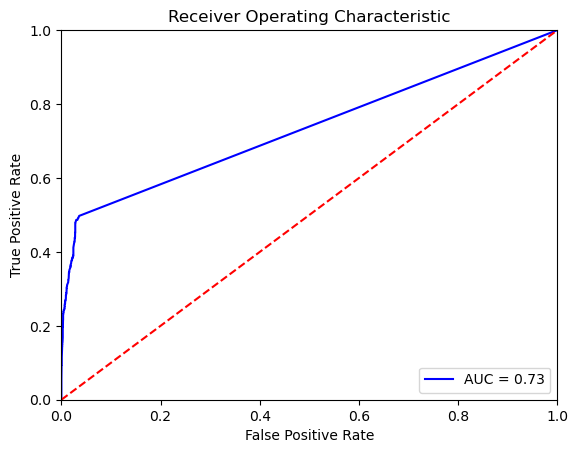

In [52]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.77%
------------------------------------------------
Confusion Matrix:
      0   1
0  5511   3
1   305  69
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5514
           1       0.96      0.18      0.31       374

    accuracy                           0.95      5888
   macro avg       0.95      0.59      0.64      5888
weighted avg       0.95      0.95      0.93      5888



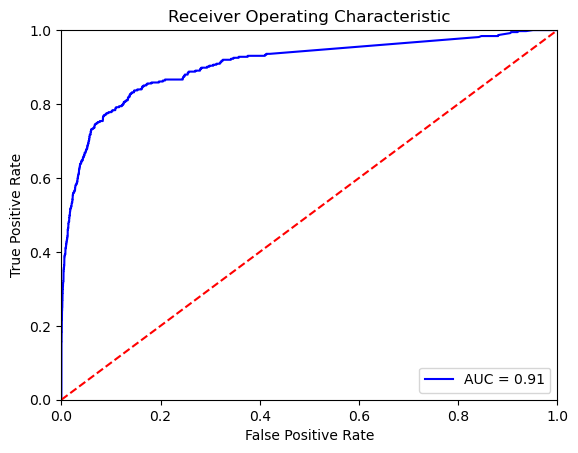

In [53]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 87.89%
------------------------------------------------
Confusion Matrix:
      0    1
0  4892  622
1    91  283
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      5514
           1       0.31      0.76      0.44       374

    accuracy                           0.88      5888
   macro avg       0.65      0.82      0.69      5888
weighted avg       0.94      0.88      0.90      5888



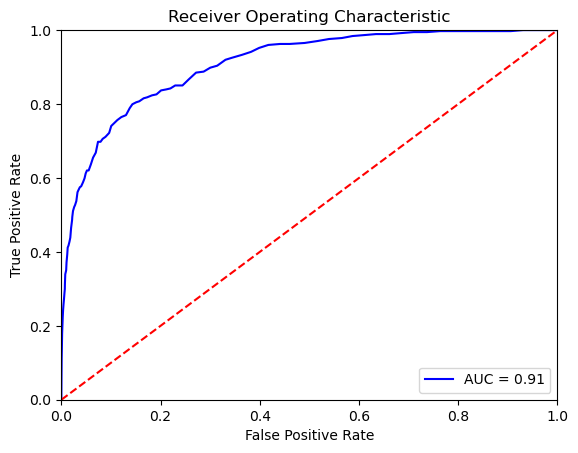

In [54]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.35%
------------------------------------------------
Confusion Matrix:
      0    1
0  5493   21
1   253  121
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5514
           1       0.85      0.32      0.47       374

    accuracy                           0.95      5888
   macro avg       0.90      0.66      0.72      5888
weighted avg       0.95      0.95      0.94      5888



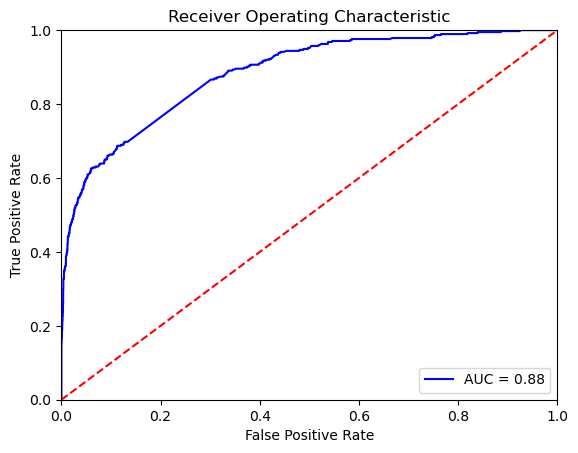

In [55]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.13%
------------------------------------------------
Confusion Matrix:
      0    1
0  5480   34
1   253  121
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5514
           1       0.78      0.32      0.46       374

    accuracy                           0.95      5888
   macro avg       0.87      0.66      0.72      5888
weighted avg       0.94      0.95      0.94      5888



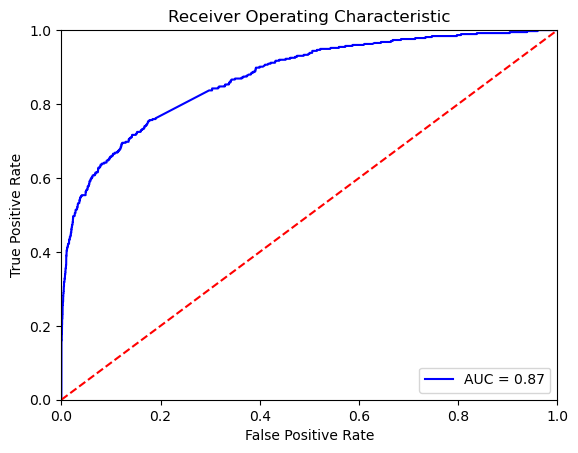

In [56]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.99%
------------------------------------------------
Confusion Matrix:
      0    1
0  5486   28
1   267  107
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.79      0.29      0.42       374

    accuracy                           0.95      5888
   macro avg       0.87      0.64      0.70      5888
weighted avg       0.94      0.95      0.94      5888



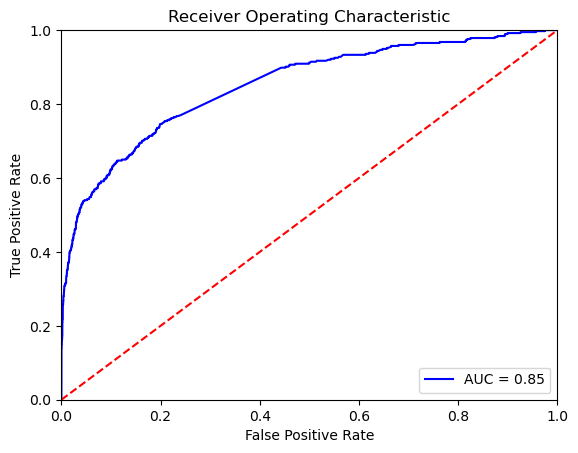

In [57]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:18] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 95.02%
------------------------------------------------
Confusion Matrix:
      0    1
0  5479   35
1   258  116
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5514
           1       0.77      0.31      0.44       374

    accuracy                           0.95      5888
   macro avg       0.86      0.65      0.71      5888
weighted avg       0.94      0.95      0.94      5888



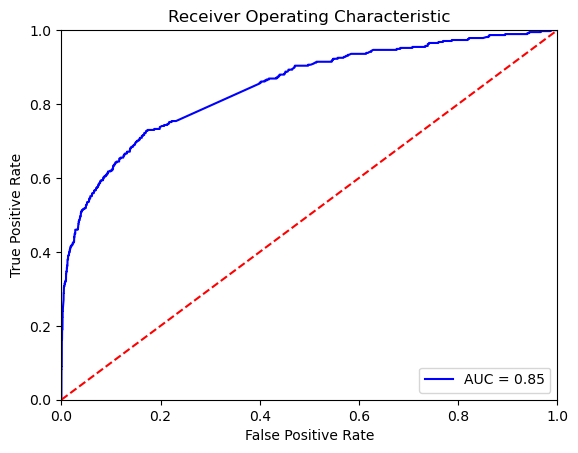

In [58]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.5882532	total: 36.5ms	remaining: 3.61s
1:	learn: 0.5073868	total: 68.5ms	remaining: 3.35s
2:	learn: 0.4435394	total: 100ms	remaining: 3.23s
3:	learn: 0.3934569	total: 134ms	remaining: 3.21s
4:	learn: 0.3586305	total: 167ms	remaining: 3.18s
5:	learn: 0.3287872	total: 199ms	remaining: 3.11s
6:	learn: 0.3042085	total: 231ms	remaining: 3.07s
7:	learn: 0.2865971	total: 265ms	remaining: 3.05s
8:	learn: 0.2730861	total: 298ms	remaining: 3.01s
9:	learn: 0.2610038	total: 330ms	remaining: 2.97s
10:	learn: 0.2520457	total: 362ms	remaining: 2.92s
11:	learn: 0.2444676	total: 394ms	remaining: 2.89s
12:	learn: 0.2377966	total: 427ms	remaining: 2.86s
13:	learn: 0.2321789	total: 465ms	remaining: 2.86s
14:	learn: 0.2276679	total: 500ms	remaining: 2.83s
15:	learn: 0.2239785	total: 536ms	remaining: 2.81s
16:	learn: 0.2208500	total: 569ms	remaining: 2.78s
17:	learn: 0.2181049	total: 603ms	remaining: 2.75s
18:	learn: 0.2157696	total: 634ms	remaining: 2.7s
19:	learn: 0.2134732	total: 672ms	remain

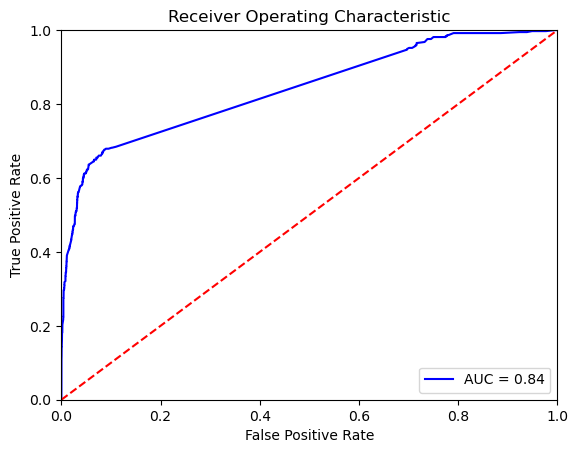

In [59]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 930, number of negative: 12807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22334
[LightGBM] [Info] Number of data points in the train set: 13737, number of used features: 922
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067700 -> initscore=-2.622563
[LightGBM] [Info] Start training from score -2.622563
model accuracy for classification is = 94.92%
------------------------------------------------
Confusion Matrix:
      0    1
0  5470   44
1   255  119
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5514
           1       0.73      0.32      0.44       374

    accuracy                           0.95      5888


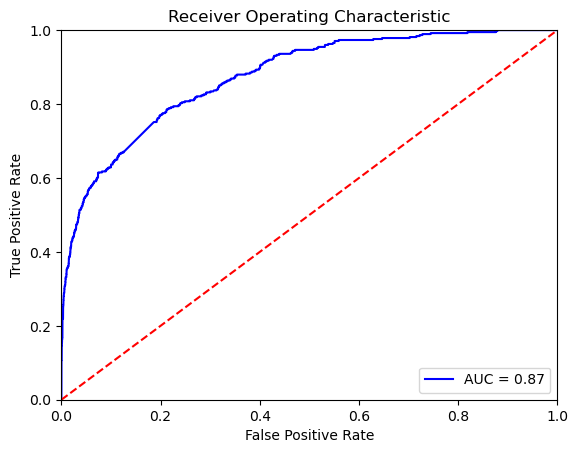

In [60]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.58%
------------------------------------------------
Confusion Matrix:
      0    1
0  5464   50
1   210  164
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5514
           1       0.77      0.44      0.56       374

    accuracy                           0.96      5888
   macro avg       0.86      0.71      0.77      5888
weighted avg       0.95      0.96      0.95      5888



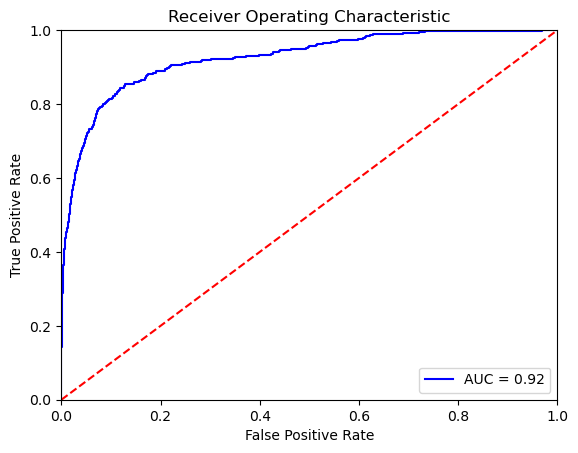

In [61]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

In [62]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 94.16%
------------------------------------------------
Confusion Matrix:
      0   1
0  5504  10
1   334  40
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.80      0.11      0.19       374

    accuracy                           0.94      5888
   macro avg       0.87      0.55      0.58      5888
weighted avg       0.93      0.94      0.92      5888



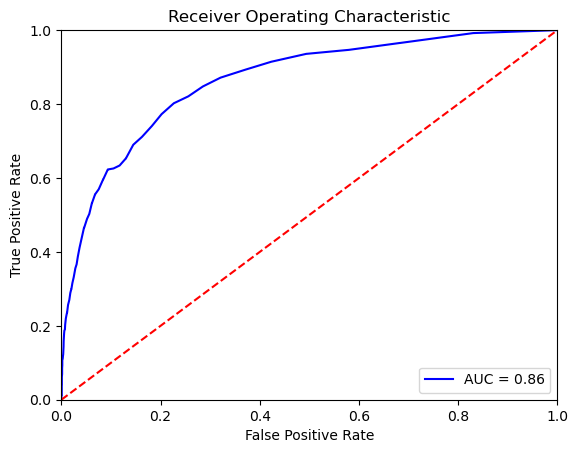

In [63]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 93.94%
------------------------------------------------
Confusion Matrix:
      0   1
0  5506   8
1   349  25
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.76      0.07      0.12       374

    accuracy                           0.94      5888
   macro avg       0.85      0.53      0.55      5888
weighted avg       0.93      0.94      0.91      5888



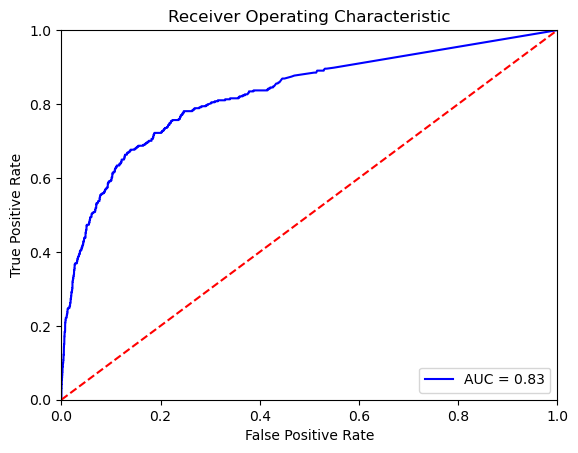

In [64]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.12%
------------------------------------------------
Confusion Matrix:
      0   1
0  5508   6
1   340  34
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5514
           1       0.85      0.09      0.16       374

    accuracy                           0.94      5888
   macro avg       0.90      0.54      0.57      5888
weighted avg       0.94      0.94      0.92      5888



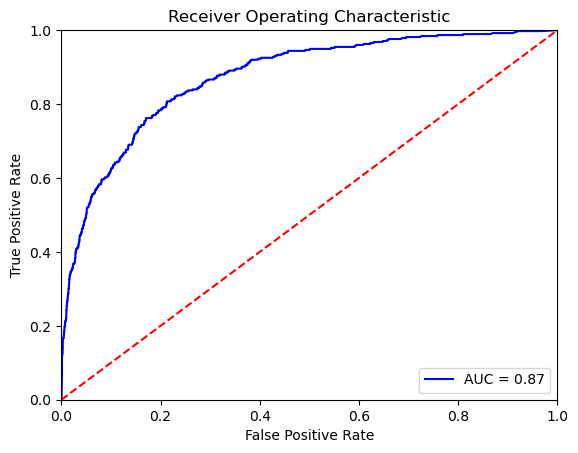

In [65]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 83.42%
------------------------------------------------
Confusion Matrix:
      0    1
0  4600  914
1    62  312
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      5514
           1       0.25      0.83      0.39       374

    accuracy                           0.83      5888
   macro avg       0.62      0.83      0.65      5888
weighted avg       0.94      0.83      0.87      5888



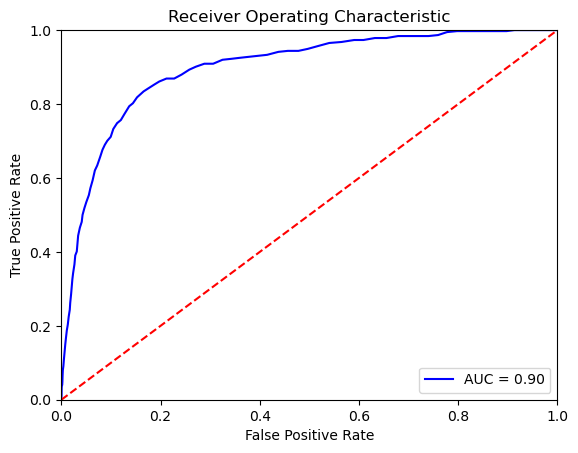

In [66]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.79%
------------------------------------------------
Confusion Matrix:
      0    1
0  5472   42
1   265  109
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.72      0.29      0.42       374

    accuracy                           0.95      5888
   macro avg       0.84      0.64      0.69      5888
weighted avg       0.94      0.95      0.94      5888



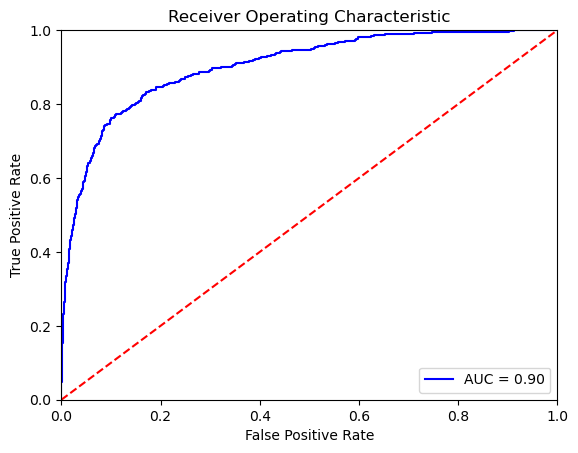

In [67]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.82%
------------------------------------------------
Confusion Matrix:
      0   1
0  5486  28
1   277  97
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.78      0.26      0.39       374

    accuracy                           0.95      5888
   macro avg       0.86      0.63      0.68      5888
weighted avg       0.94      0.95      0.94      5888



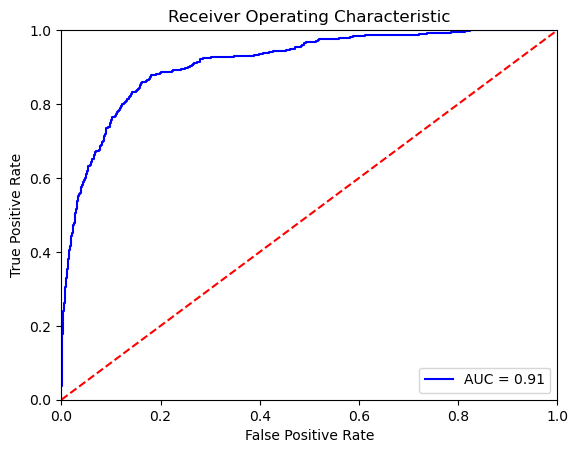

In [68]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.70%
------------------------------------------------
Confusion Matrix:
      0    1
0  5472   42
1   270  104
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.71      0.28      0.40       374

    accuracy                           0.95      5888
   macro avg       0.83      0.64      0.69      5888
weighted avg       0.94      0.95      0.94      5888



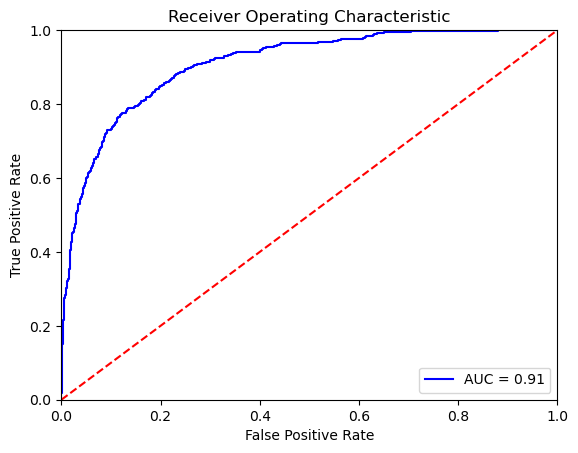

In [69]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:39] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.23%
------------------------------------------------
Confusion Matrix:
      0   1
0  5453  61
1   279  95
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.61      0.25      0.36       374

    accuracy                           0.94      5888
   macro avg       0.78      0.62      0.66      5888
weighted avg       0.93      0.94      0.93      5888



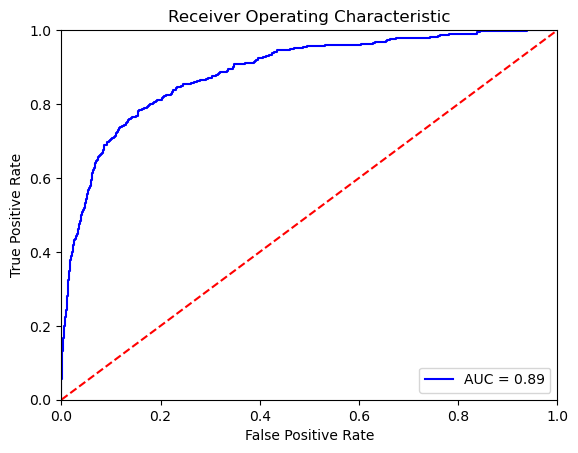

In [70]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.5801904	total: 13.9ms	remaining: 1.38s
1:	learn: 0.4957667	total: 26.4ms	remaining: 1.29s
2:	learn: 0.4207297	total: 38.5ms	remaining: 1.25s
3:	learn: 0.3686039	total: 50.7ms	remaining: 1.22s
4:	learn: 0.3270664	total: 63.5ms	remaining: 1.21s
5:	learn: 0.2961771	total: 75.2ms	remaining: 1.18s
6:	learn: 0.2710451	total: 87.1ms	remaining: 1.16s
7:	learn: 0.2533867	total: 99.5ms	remaining: 1.14s
8:	learn: 0.2386264	total: 112ms	remaining: 1.13s
9:	learn: 0.2263644	total: 124ms	remaining: 1.12s
10:	learn: 0.2194754	total: 136ms	remaining: 1.1s
11:	learn: 0.2124197	total: 148ms	remaining: 1.08s
12:	learn: 0.2066104	total: 160ms	remaining: 1.07s
13:	learn: 0.2019810	total: 172ms	remaining: 1.06s
14:	learn: 0.1970665	total: 185ms	remaining: 1.05s
15:	learn: 0.1934330	total: 197ms	remaining: 1.03s
16:	learn: 0.1906983	total: 209ms	remaining: 1.02s
17:	learn: 0.1881943	total: 222ms	remaining: 1.01s
18:	learn: 0.1857003	total: 235ms	remaining: 1s
19:	learn: 0.1834652	total: 248ms	rem

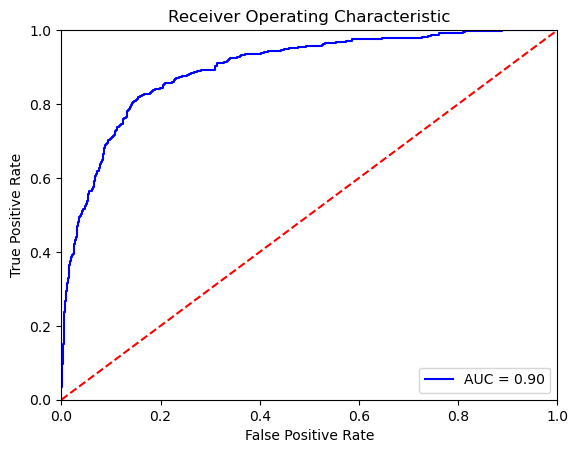

In [71]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 930, number of negative: 12807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 13737, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067700 -> initscore=-2.622563
[LightGBM] [Info] Start training from score -2.622563
model accuracy for classification is = 94.62%
------------------------------------------------
Confusion Matrix:
      0   1
0  5476  38
1   279  95
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.71      0.25      0.37       374

    accuracy                           0.95      5888
   macro avg       0.83      0.62      0.67      5888
weighted avg 

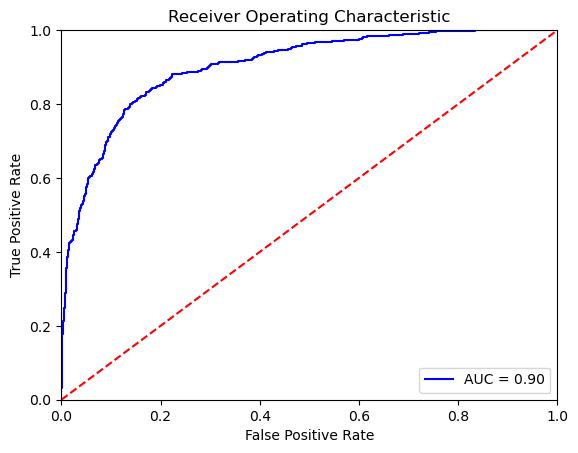

In [72]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.31%
------------------------------------------------
Confusion Matrix:
      0   1
0  5462  52
1   283  91
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5514
           1       0.64      0.24      0.35       374

    accuracy                           0.94      5888
   macro avg       0.79      0.62      0.66      5888
weighted avg       0.93      0.94      0.93      5888



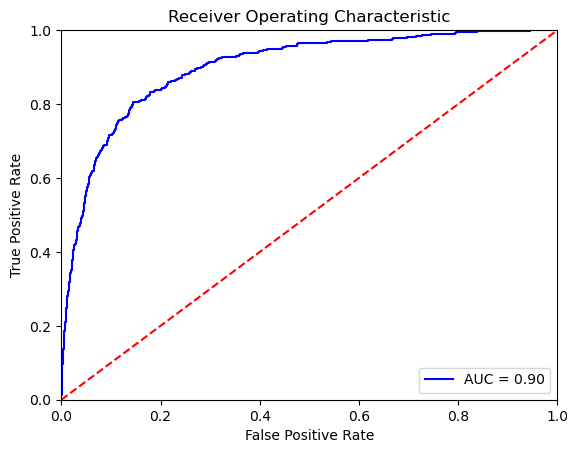

In [73]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

In [74]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove200d", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

### Model Evaluation

In [75]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
22,StackingClassifier-RF-SVC,untuned,tf,0.995559,0.997709,0.936559,0.966167,0.955842,0.766355,0.438503,0.557823
12,RandomForest,untuned,tf,0.999927,1.000000,0.998925,0.999462,0.955333,0.776119,0.417112,0.542609
23,SVC,untuned,tf,0.983766,0.980952,0.775269,0.866066,0.953465,0.740385,0.411765,0.529210
16,XGBoost,untuned,tf,0.959525,0.947368,0.425806,0.587537,0.953465,0.852113,0.323529,0.468992
17,XGBoost,gridsearch,tf,0.961709,0.929787,0.469892,0.624286,0.951257,0.780645,0.323529,0.457467
21,LightGBM,untuned,tf,0.959671,0.927273,0.438710,0.595620,0.949219,0.730061,0.318182,0.443203
15,BalancedRandomForest,untuned,tf,0.908641,0.425629,1.000000,0.597111,0.878906,0.312707,0.756684,0.442533
19,XGBoost,optuna,tf,0.955667,0.877647,0.401075,0.550554,0.950238,0.768212,0.310160,0.441905
18,XGBoost,randsearch,tf,0.950863,0.869565,0.322581,0.470588,0.949898,0.792593,0.286096,0.420432
28,XGBoost,untuned,glove,0.999927,1.000000,0.998925,0.999462,0.947860,0.721854,0.291444,0.415238


#### Test on new data

In [76]:
df_train_new_cleaned = pd.read_csv("..\\..\\..\\data\\new_datasets\\train_cleaned.csv")
df_train_new_cleaned = df_train_new_cleaned[df_train_new_cleaned.tweet_cleaned.notna()]

In [77]:
X_data = df_train_new_cleaned["tweet_cleaned"]
y_data = df_train_new_cleaned["label"]


X_data_vectorized = tf_model.transform(X_data)

model accuracy for classification is = 74.23%
------------------------------------------------
Confusion Matrix:
       0     1
0  42832  5322
1  10466  2637
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     48154
           1       0.33      0.20      0.25     13103

    accuracy                           0.74     61257
   macro avg       0.57      0.55      0.55     61257
weighted avg       0.70      0.74      0.72     61257



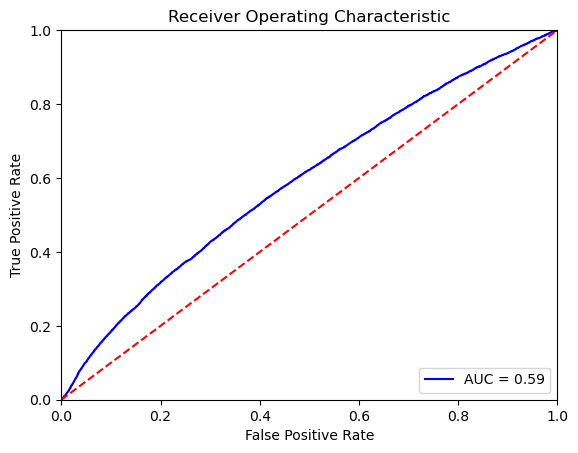

In [78]:
evaluate_model(stack_untuned_tf, X_data_vectorized, y_data)

model accuracy for classification is = 74.23%
------------------------------------------------
Confusion Matrix:
       0     1
0  42832  5322
1  10466  2637
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     48154
           1       0.33      0.20      0.25     13103

    accuracy                           0.74     61257
   macro avg       0.57      0.55      0.55     61257
weighted avg       0.70      0.74      0.72     61257



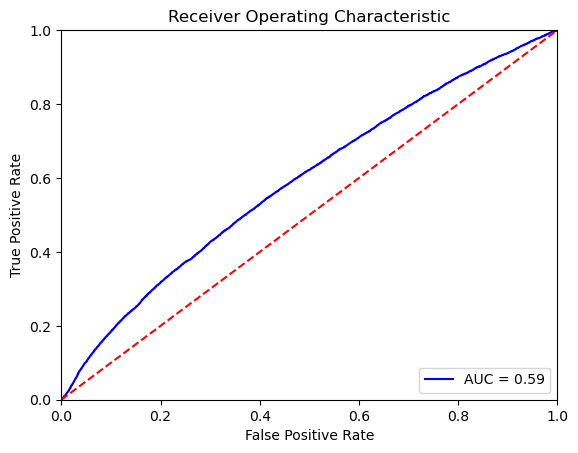

In [79]:
evaluate_model(stack_untuned_tf, X_data_vectorized, y_data)